In [1]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [9]:
import os
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from irelease.utils import generate_smiles
from nb_utils import initialize, data_provider, agent_net_hidden_states_func, evaluate, device, load_model, logp_ppo_hparams

In [3]:
with open('logp_IReLeaSE-REINFORCE_no_irl.json', 'r') as f:
    reinf_train_hist = json.load(f)
with open('logp_IReLeaSE-ppo_with_irl_no_attn.json', 'r') as f:
    ppo_train_hist = json.load(f)

In [4]:
rl_baseline_mean_vals = reinf_train_hist['logp_IReLeaSE-REINFORCE_no_irl'][0]['seed_1'][0]['baseline_mean_vals']
rl_biased_mean_vals = reinf_train_hist['logp_IReLeaSE-REINFORCE_no_irl'][0]['seed_1'][1]['biased_mean_vals']
rl_gen_mean_vals = reinf_train_hist['logp_IReLeaSE-REINFORCE_no_irl'][0]['seed_1'][2]['gen_mean_vals']
len(rl_baseline_mean_vals), len(rl_biased_mean_vals), len(rl_gen_mean_vals)

(600, 600, 600)

In [5]:
ppo_baseline_mean_vals = ppo_train_hist['logp_IReLeaSE-ppo_with_irl_no_attn'][0]['seed_1'][0]['baseline_mean_vals']
ppo_biased_mean_vals = ppo_train_hist['logp_IReLeaSE-ppo_with_irl_no_attn'][0]['seed_1'][1]['biased_mean_vals']
ppo_gen_mean_vals = ppo_train_hist['logp_IReLeaSE-ppo_with_irl_no_attn'][0]['seed_1'][2]['gen_mean_vals']
len(ppo_baseline_mean_vals), len(ppo_biased_mean_vals), len(ppo_gen_mean_vals)

(500, 500, 500)

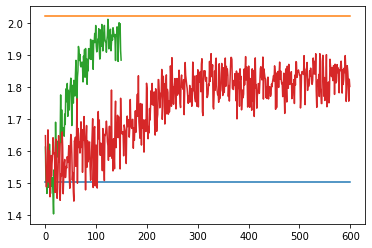

In [6]:
plt.plot(rl_baseline_mean_vals)
plt.plot(rl_biased_mean_vals)
plt.plot(ppo_gen_mean_vals[:150])
plt.plot(rl_gen_mean_vals)

In [10]:
generators = data_provider('../../data/logp_smiles_biased.smi', '../../data/unbiased_smiles.smi')

In [12]:
init_dict = initialize(logp_ppo_hparams(),generators['demo_data'], generators['unbiased_data'], True)

In [13]:
weights = load_model('../model_dir/logp_irelease_stack-rnn_gru_ppo_agent_2020_06_25__01_31_53_1.978_500.mod')
agent_net = init_dict['agent_net']
agent_net.load_state_dict(weights)

<All keys matched successfully>

In [14]:
demo_data_gen = init_dict['demo_data_gen']
unbiased_data_gen = init_dict['unbiased_data_gen']

In [15]:
with torch.set_grad_enabled(False):
    samples = []
    for i in range(5):
        samples.extend(generate_smiles(agent_net,init_dict['demo_data_gen'],init_dict['gen_args'],
                             num_samples=200, is_train=False, verbose=True))
len(samples)

Processing SMILES...: 100%|██████████| 200/200 [00:00<00:00, 17251.64it/s]


1000

In [16]:
expert_model = init_dict['expert_model']

In [17]:
samples_predictions = expert_model(samples)[1]

In [19]:
unbiased_smiles = unbiased_data_gen.random_training_set_smiles(len(samples))
unbiased_smiles_predictions = expert_model(unbiased_smiles)[1]
len(unbiased_smiles), unbiased_smiles[0]

(1000, 'CCCCn1cc(NC(=O)c2ccccc2C(N)=O)nn1')

In [20]:
biased_smiles = demo_data_gen.random_training_set_smiles(len(samples))
biased_smiles_predictions = expert_model(biased_smiles)[1]
len(biased_smiles), biased_smiles[0]

(1000, 'Cc1cccc(-c2cccc(-c3ccccc3Cc3cccc(-c4ccccc4Nc4ccccc4)c3)c2)c1')

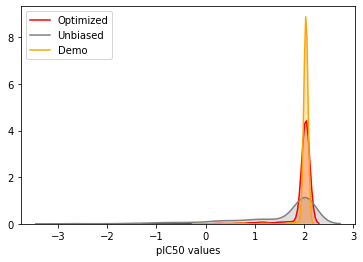

In [21]:
sns.kdeplot(samples_predictions.ravel(),label='Optimized', shade=True, color='red')
sns.kdeplot(unbiased_smiles_predictions.ravel(), label='Unbiased', shade=True, color='grey')
sns.kdeplot(biased_smiles_predictions.ravel(), label='Demo', shade=True, color='orange')
plt.xlabel('pIC50 values')
plt.show()